In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
!pip install lifetimes
import pandas as pd
from lifetimes import BetaGeoFitter, GammaGammaFitter

from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data


from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions, plot_calibration_purchases_vs_holdout_purchases

# Customer Lifetime value

We used the lifetimes library to calculate customer lifetime value.

We made frequency/recency analysis using the BG/NBD model to calculate future purchase. This was visually evaluated with a train/test split of the data.

The BG/NBD model was the fitted to all of the data, and CLV was calculated using the Gamma Gamma model.

In [ ]:
data = pd.read_parquet('/content/drive/MyDrive/BCG/datasets/transactions_dataset.parquet')

In [ ]:
data.drop(['date_invoice', 'product_id', 'quantity', 'order_channel', 'branch_id'], axis = 1, inplace = True )
data = data[data['sales_net'] > 0]
data[data['client_id']==6].head()

,date_order,client_id,sales_net
2012229,2017-10-27,6,55.821000
2029384,2017-10-27,6,21.046886
2048291,2017-10-27,6,20.470000
2055732,2017-10-27,6,8.418000
2059798,2017-10-27,6,48.467072


In [ ]:
#We use daily sales, since the granularity of the rows is per product.
data_daily = data.groupby(['date_order', 'client_id']).agg({'sales_net': 'sum'}).reset_index()

In [ ]:
data_daily['date_order'].max()

'2019-09-22'

In [ ]:
#Create summary to explore the data.
clients = summary_data_from_transaction_data(data_daily, "client_id", "date_order", 'sales_net', observation_period_end='2019-09-22')
clients = clients.reset_index()
clients.head()

,client_id,frequency,recency,T,monetary_value
0,6,12.0,655.0,695.0,377.011927
1,7,1.0,161.0,433.0,481.204467
2,14,504.0,725.0,727.0,6246.709214
3,18,290.0,716.0,726.0,846.981528
4,25,0.0,0.0,347.0,0.000000


In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(clients['frequency'], clients['recency'], clients['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 170586 subjects, a: 0.08, alpha: 6.14, b: 3.07, r: 0.48>


In [ ]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.481503,0.001573,0.478421,0.484585
alpha,6.139485,0.029744,6.081186,6.197783
a,0.084542,0.000962,0.082657,0.086428
b,3.069977,0.070690,2.931424,3.208529


/usr/local/lib/python3.10/dist-packages/lifetimes/fitters/beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in scalar power
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

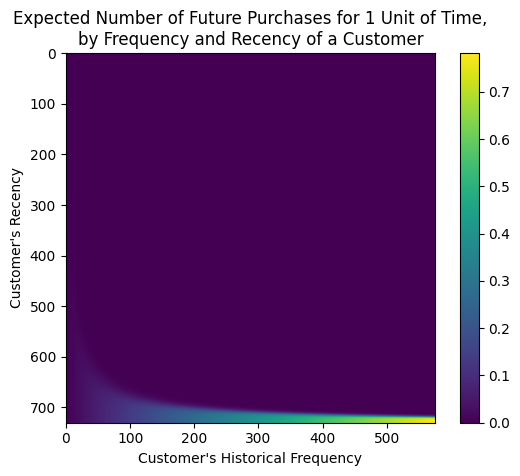

In [ ]:
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

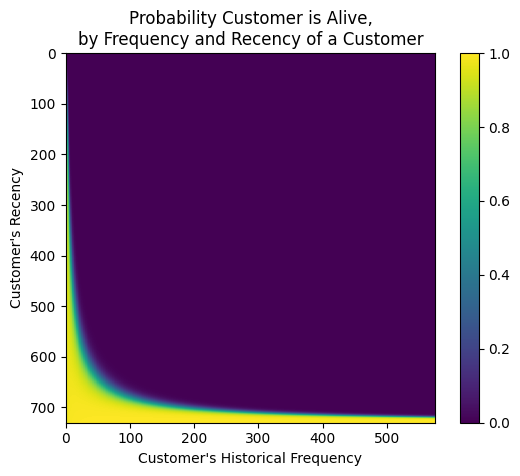

In [ ]:
plot_probability_alive_matrix(bgf)

The plots look reasonable. Recency is days since first purchase.

In [ ]:
#Split data to calibration, holdout (train, test)
clients_cal_holdout = calibration_and_holdout_data(data_daily, 'client_id', 'date_order',
                                        calibration_period_end='2019-07-22',
                                        observation_period_end='2019-09-22')
clients_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
client_id,,,,,
6,9.0,474.0,633.0,3.0,62.0
7,1.0,161.0,371.0,0.0,62.0
14,462.0,665.0,665.0,42.0,62.0
18,264.0,664.0,664.0,26.0,62.0
25,0.0,0.0,285.0,0.0,62.0


In [ ]:
#Fit the model
bgf.fit(clients_cal_holdout['frequency_cal'], clients_cal_holdout['recency_cal'], clients_cal_holdout['T_cal'])

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

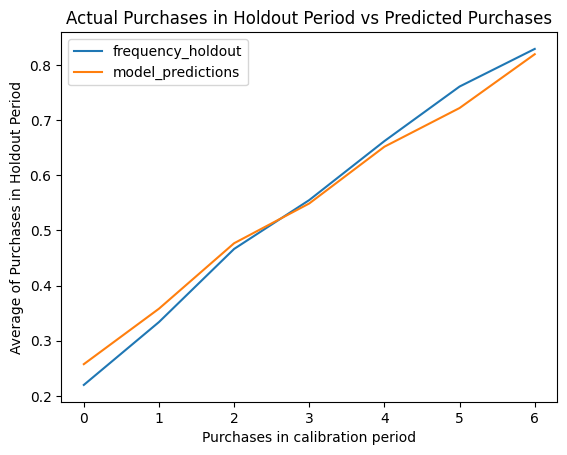

In [ ]:
plot_calibration_purchases_vs_holdout_purchases(bgf, clients_cal_holdout)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

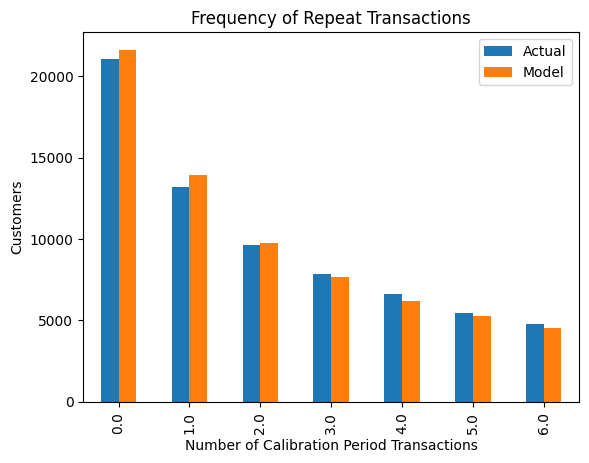

In [ ]:
plot_period_transactions(bgf)

The model seems to produce similar results to the actual purchasing pattern.

Now we can calculate the CLV on the whole dataset

In [ ]:
#The Gamma Gamma model can not have negative or zero monetary value
clients = clients[clients['monetary_value'] > 0]
#The model can not have a substantial correlation between monetary value and frequency
clients[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.082121
frequency,0.082121,1.000000


In [ ]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(clients['frequency'],
        clients['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 149499 subjects, p: 0.65, q: 2.16, v: 1580.39>


In [ ]:
clients['expected_avg_transaction'] = ggf.conditional_expected_average_profit(
        clients['frequency'],
        clients['monetary_value'])


In [ ]:
bgf.fit(clients['frequency'], clients['recency'], clients['T'])

clients['CLV']=ggf.customer_lifetime_value(
    bgf,
    clients['frequency'],
    clients['recency'],
    clients['T'],
    clients['monetary_value'],
    time=12,
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

In [ ]:
clients.drop(['expected_avg_transaction'], axis = 1, inplace = True)

In [ ]:
clients.head()

,client_id,frequency,recency,T,monetary_value,expected_purchases,expected_avg_transaction,CLV
0,6,12.0,655.0,695.0,377.011927,0.123027,442.958600,2.622522e+03
1,7,1.0,161.0,433.0,481.204467,0.021168,741.242339,8.074874e+02
2,14,504.0,725.0,727.0,6246.709214,4.811658,6227.834149,1.418960e+06
3,18,290.0,716.0,726.0,846.981528,2.733211,847.227220,1.097289e+05
5,37,14.0,568.0,677.0,428.391658,0.139251,480.181403,3.201522e+03


In [ ]:
clients.to_parquet('/content/drive/MyDrive/BCG/datasets/clv_rfmBaseline.parquet')